In [2]:
def show_image(img, mod_img):
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(mod_img, cmap='gray')
    ax2.set_title('Modified Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import glob

def calibra_camera():
    images = glob.glob(".\\camera_cal\\calibration*.jpg")

    objpoints = [] # 3D points
    imgpoints = [] # 2D points in image plane

    objp = np.zeros((6*9, 3), np.float32)
    objp[:,:2] = (np.mgrid[0:9,0:6].T.reshape(-1,2 ))

    for fname in images:
        img = mpimg.imread(fname)
        #plt.imshow(img)
    
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
        
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #plt.imshow(img)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

In [4]:
def undistort(img, mtx, dist, show):
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    if show == True:
        show_image(img, undist_img)
    return undist_img

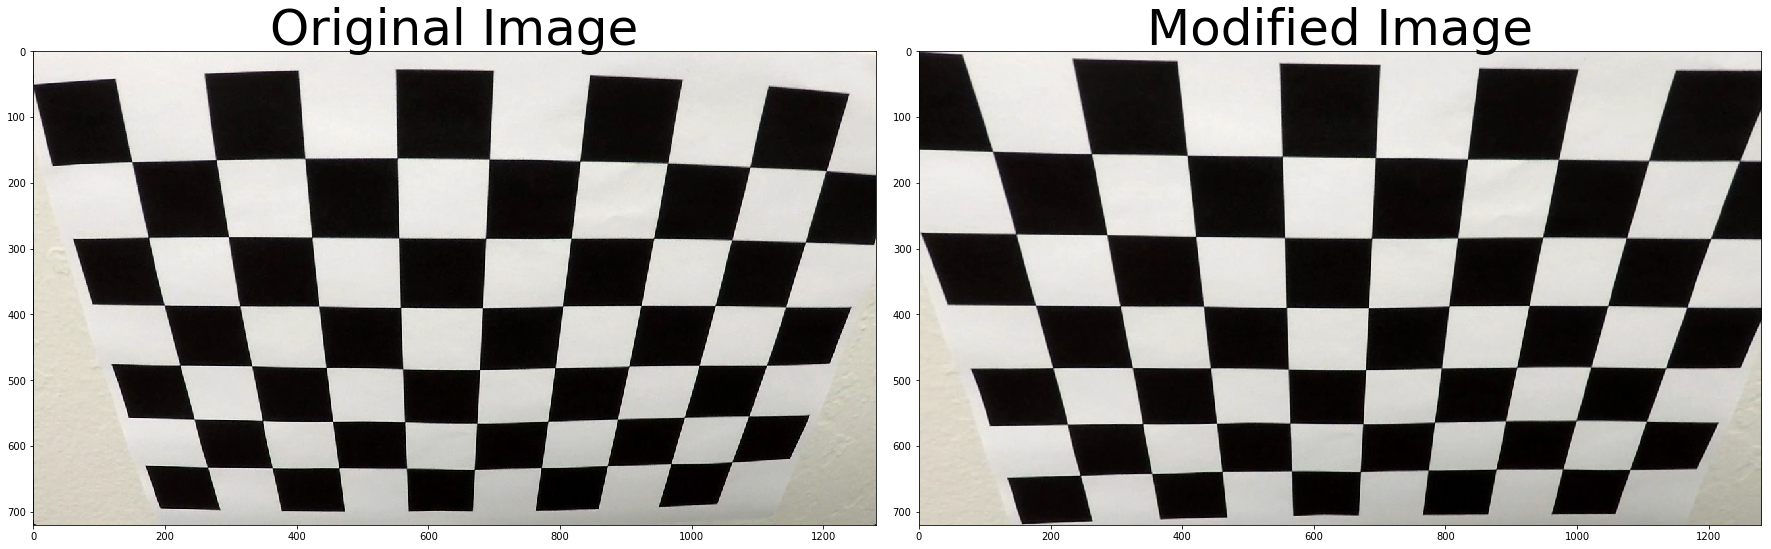

In [5]:
mtx, dist = calibra_camera()
test_img = mpimg.imread(".\\camera_cal\\calibration2.jpg")
undist_img = undistort(test_img, mtx, dist, True)

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255, gray_scale = 0):
    if (gray_scale == 1):
        gray = img
    else :
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        abs_sobel = np.absolute(sobel)
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(.7, 1.3)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [7]:
def r_channel_color_threshold2(img, show):
    thresh = (150, 255)
    r_channel = img[:,:,0]
    binary = np.zeros_like(r_channel)
    binary[(r_channel > thresh[0]) & (r_channel <= thresh[1])] = 1
    if show == True:
        show_image(img, binary)

    return binary
def r_channel_color_threshold(img, show):
    thresh = (180, 255)
    r_channel = img[:,:,0]
    binary = np.zeros_like(r_channel)
    binary[(r_channel > thresh[0]) & (r_channel <= thresh[1])] = 1
    if show == True:
        show_image(img, binary)

    return binary

def s_channel_color_threshold(img, show):
    thresh = (170, 255)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary = np.zeros_like(s_channel)
    binary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    if show == True:
        show_image(img, binary)

    return binary

def l_channel_color_threshold(img, show):
    thresh = (150, 255)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,1]
    binary = np.zeros_like(s_channel)
    binary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    if show == True:
        show_image(img, binary)

    return binary

In [8]:
def color_gradient_threshold(img, show, mode):
    ksize = 5
    sxbinary = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh_min=15, thresh_max=100, gray_scale = 0)
    #grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh_min=20, thresh_max=150)
    #mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 150))
    #dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))
    
    sbinary = s_channel_color_threshold(img, show=False)
    lbinary = l_channel_color_threshold(img, show=False)
    rbinary = r_channel_color_threshold(img, show=False)
    rbinary2 = r_channel_color_threshold2(img, show=False)
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    if (mode == 1) :
        combined_binary[((sbinary == 1)) | ((sxbinary == 1) ) ] = 1
    elif (mode == 2) :
        combined_binary[((sbinary == 1) & (rbinary == 1)) | ((sxbinary == 1) ) ] = 1
    elif (mode == 3) :
        combined_binary[((sbinary == 1) & (rbinary == 1)) | ((sxbinary == 1) & (rbinary2 == 1)) ] = 1    
    if show == True:
        show_image(img, combined_binary)

    return combined_binary

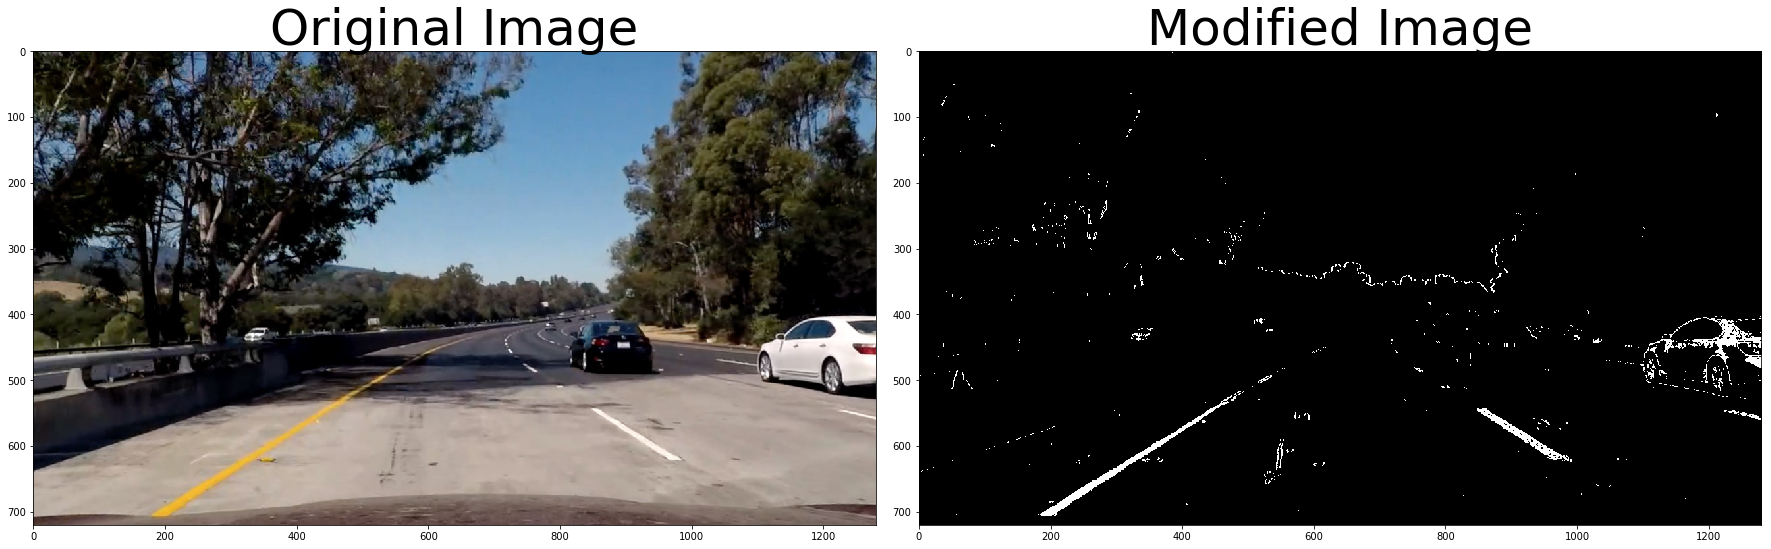

In [10]:
#img = mpimg.imread('.\\test_images\\challenge01.jpg')
#undist_img = undistort(img, mtx, dist, False)
#mod_img = color_gradient_threshold(undist_img, show=True, mode=3)
img = mpimg.imread('.\\test_images\\test5.jpg')
undist_img = undistort(img, mtx, dist, False)
mod_img = color_gradient_threshold(undist_img, show=True, mode=3)


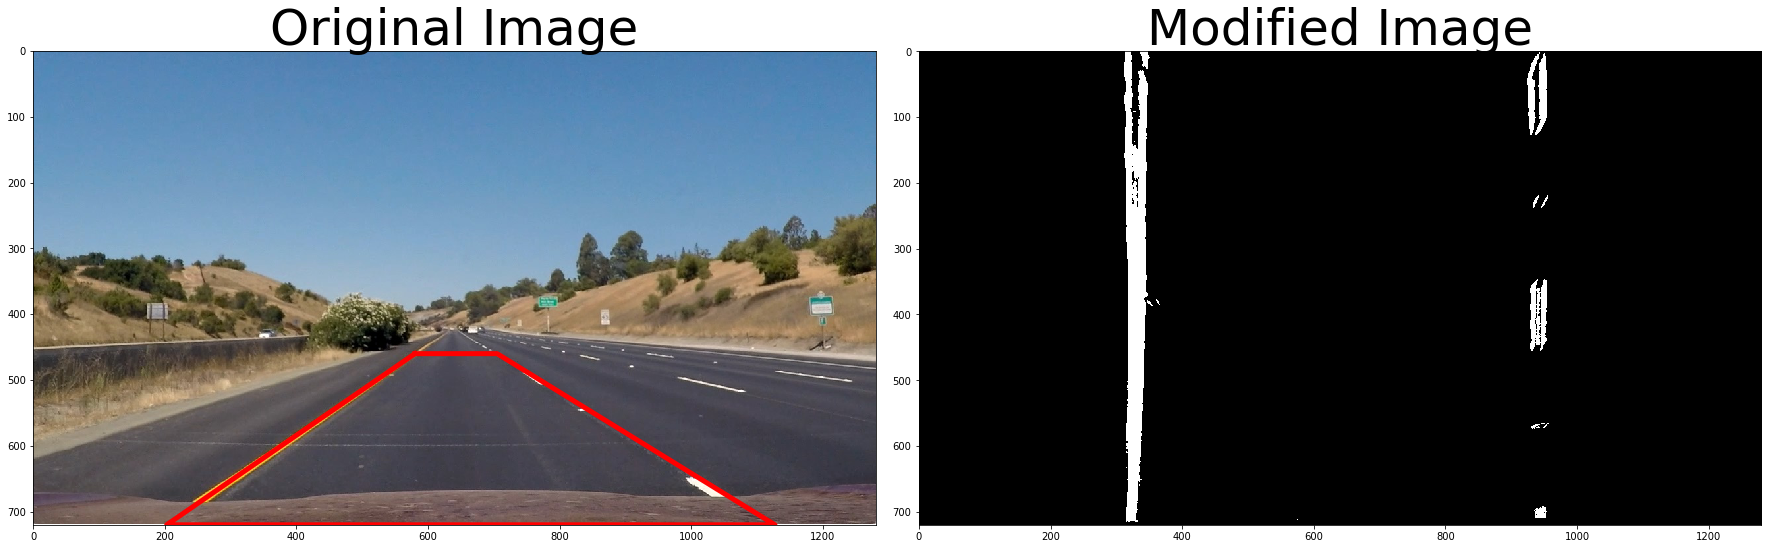

In [9]:
def perspective_transform(undist, src, dst):
    image_size = (undist.shape[1], undist.shape[0])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, image_size)

    # Return the resulting image and matrix
    return warped, M, Minv

img = mpimg.imread('.\\test_images\\straight_lines1.jpg')
undist_img = undistort(img, mtx, dist, False)

h,w = mod_img.shape[:2]

# define source and destination points for transform
src = np.float32([(580, 460), (705, 460), (203, 720), (1127, 720) ])
dst = np.float32([(320, 0), (960, 0), (320, 720), (960, 720)])    

warped, M, Minv = perspective_transform(undist_img, src, dst)
binary_warped = color_gradient_threshold(warped, show=False, mode=3)
    
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='red', linewidth=5)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Modified Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    


In [10]:
def img_procesing_pipeline_1(img):
    undist_img = undistort(img, mtx, dist, False)
    warped, M, Minv = perspective_transform(undist_img, src, dst)
    mod_img = color_gradient_threshold(warped, show=False, mode=3)
    return mod_img, warped, Minv

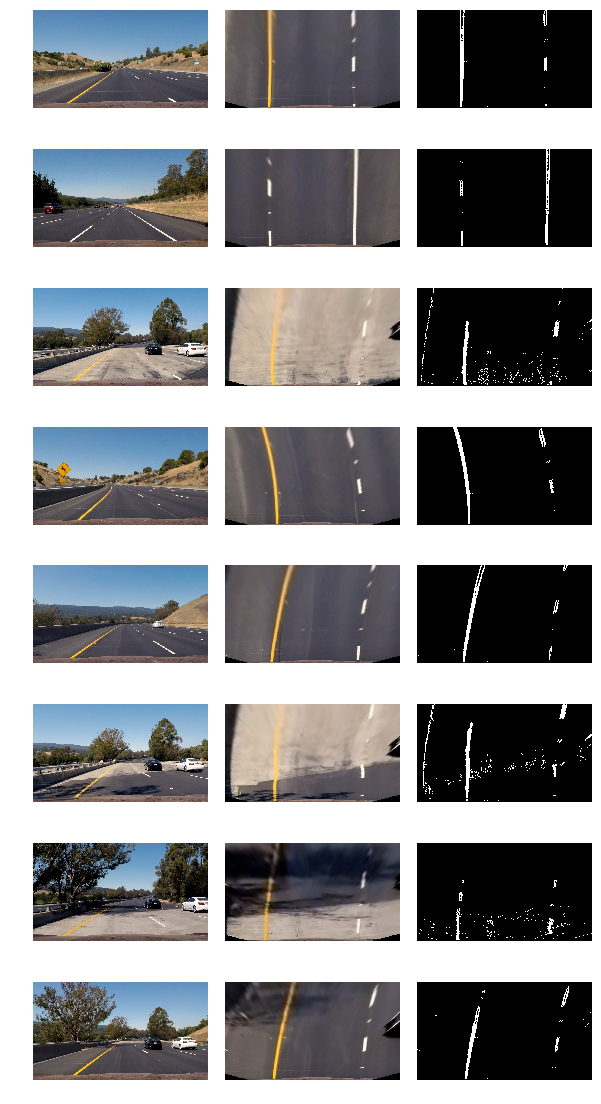

In [11]:
# Make a list of example images
images = glob.glob('.\\test_images\\*.jpg')
                                           
# Set up plot
fig, axs = plt.subplots(len(images), 3, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin, warped, Minv = img_procesing_pipeline_1(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(warped)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1



In [12]:
def sliding_window_polyfit(binary_warped, margin, minpixn):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_yleft_low = binary_warped.shape[0] - (window+1)*window_height
        win_yleft_high = binary_warped.shape[0] - window*window_height

        win_yright_low = binary_warped.shape[0] - (window+1)*window_height
        win_yright_high = binary_warped.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_yleft_low),(win_xleft_high,win_yleft_high),
        (0,255,0), 2) 
        
        cv2.rectangle(out_img,(win_xright_low,win_yright_low),(win_xright_high,win_yright_high),
        (0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window

        good_left_inds = ((nonzeroy >= win_yleft_low) & (nonzeroy < win_yleft_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            
        good_right_inds = ((nonzeroy >= win_yright_low) & (nonzeroy < win_yright_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit = None
    right_fit = None
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
        
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, histogram

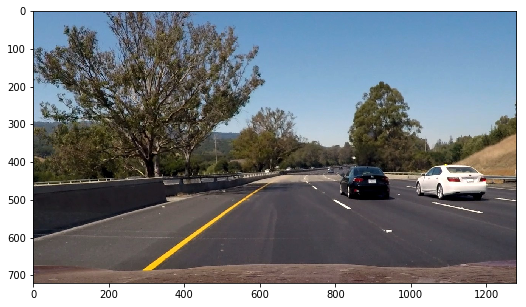

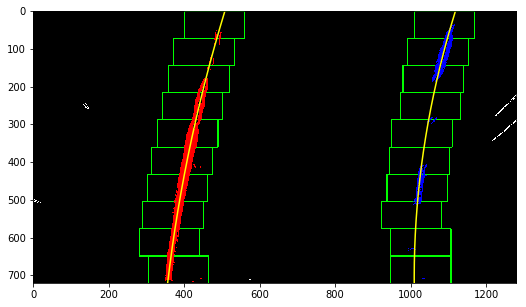

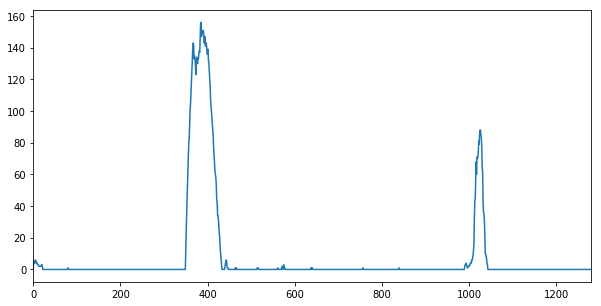

In [13]:
img = mpimg.imread('.\\test_images\\test6.jpg')

plt.figure(figsize=(10,5)) 
plt.imshow(img)
binary_warped, warped, Minv = img_procesing_pipeline_1(img)
# Set the width of the windows +/- margin
margin = 80
# Set minimum number of pixels found to recenter window
minpix = 50

left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, histogram  = sliding_window_polyfit(binary_warped, margin, minpix)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
plt.figure(figsize=(10,5)) 
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


# Print histogram from sliding window polyfit for example image
plt.figure(figsize=(10, 5))
plt.xlim(0, 1280)
plt.plot(histogram)


In [14]:
def find_lane_from_prev_fit(binary_warped, left_fit_prev, right_fit_prev, margin):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + 
    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + 
    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + 
    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + 
    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit = None
    right_fit = None
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
            
    return left_fit, right_fit, left_lane_inds, right_lane_inds

(720, 0)

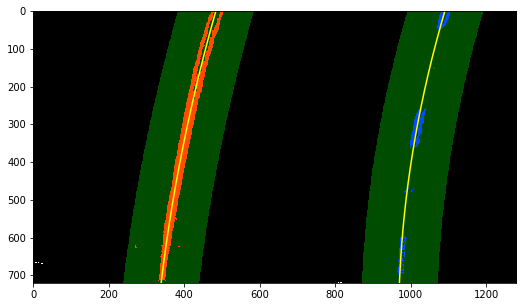

In [15]:
# visualize the result on example image
# Create an image to draw on and an image to show the selection window
img = mpimg.imread('.\\test_images\\test3.jpg')
binary_warped, warped, Minv = img_procesing_pipeline_1(img)
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100

left_fit_new, right_fit_new, left_lane_inds_new, right_lane_inds_new = find_lane_from_prev_fit(binary_warped, left_fit, right_fit, margin)

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds_new], nonzerox[left_lane_inds_new]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds_new], nonzerox[right_lane_inds_new]] = [0, 0, 255]

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
right_fitx = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.figure(figsize=(10,5)) 
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

-2181.99565858 -4471.3728884
275.018453063 894.012590292 618.994137229
380.62400496 1018.56276983 637.938764873
719 2.27146583605 6.07851975545 4.17499279575 640.0 -0.355637957043
left_lane_curvature= 634.476595767 m, right_lane_curvature= 1284.85228905 m
Distance from lane center for example: -0.355637957043 m


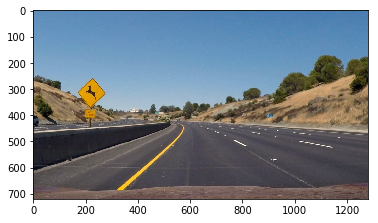

In [16]:
def cal_curvature_and_distance_from_center(img, binary_warped, left_fit, right_fit, left_fitx, right_fitx, debug, in_px):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    if left_fit is not None and right_fit is not None:
        left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / (2*left_fit[0])
        right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / (2*right_fit[0])
    if (debug) :    
        print(left_curverad, right_curverad)
        print(left_fitx[0], right_fitx[0], right_fitx[0] - left_fitx[0])
        print(left_fitx[719], right_fitx[719], right_fitx[719] - left_fitx[719])
    if (in_px) :
        return left_curverad, right_curverad, 0
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/620 # meters per pixel in x dimension
    left_curverad = 0
    right_curverad = 0
    center_dist = 0
    if (len(left_fitx) != 0 and len(right_fitx) !=0):
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
        y_eval = img.shape[0] - 1
        left_x_0 = left_fit_cr[0] * (y_eval * ym_per_pix) **2 + left_fit_cr[1] * (y_eval * ym_per_pix) + left_fit_cr[2]
        right_x_0 = right_fit_cr[0] * (y_eval * ym_per_pix) **2 + right_fit_cr[1] * (y_eval * ym_per_pix) + right_fit_cr[2]
        lane_center = (right_x_0 + left_x_0) / 2
        image_center = img.shape[1]/2
        center_dist =  image_center * xm_per_pix - lane_center
        if (debug):
            print (y_eval, left_x_0, right_x_0, lane_center, image_center, center_dist)
    return left_curverad, right_curverad, center_dist

img = mpimg.imread('.\\test_images\\test2.jpg')
#img = mpimg.imread('.\\test_images\\challenge01.jpg')
plt.imshow(img)
binary_warped, warped, Minv = img_procesing_pipeline_1(img)
left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, all_hist  = sliding_window_polyfit(binary_warped, margin, minpix)
    
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_curverad, right_curverad, center_dist = cal_curvature_and_distance_from_center(img, binary_warped, left_fit, right_fit, left_fitx, right_fitx, 1, False)
print('left_lane_curvature=', left_curverad, 'm, right_lane_curvature=', right_curverad, 'm')
print('Distance from lane center for example:', center_dist, 'm')

In [17]:
def draw_lane(img, binary_warped, left_fit, right_fit, Minv):
    new_img = np.copy(img)
    if left_fit is None or right_fit is None:
        return img
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(255,0,0), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result


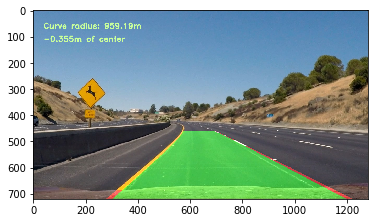

In [18]:
def write_data(img, curvature, center_dist, select):
    new_img = np.copy(img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curvature) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1, (200,255,155), 2, cv2.LINE_AA)
    #text = '{:04.3f}'.format(center_dist) + 'm of center select = ' + '{:04.0f}'.format(select)
    text = '{:04.3f}'.format(center_dist) + 'm of center'
    cv2.putText(new_img, text, (40,120), font, 1, (200,255,155), 2, cv2.LINE_AA)
    return new_img

def img_procesing_pipeline_2(img):
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    binary_warped, warped, Minv = img_procesing_pipeline_1(img)
    left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, all_hist  = sliding_window_polyfit(binary_warped, margin, minpix)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_curverad, right_curverad, center_dist = cal_curvature_and_distance_from_center(img, binary_warped, left_fit, right_fit, left_fitx, right_fitx, 0, False)    
    
    mod_img = draw_lane(img, binary_warped, left_fit, right_fit, Minv)
    mod_img = write_data(mod_img, (left_curverad + right_curverad) /2, center_dist, select = 1)
    return mod_img

img = mpimg.imread('.\\test_images\\test2.jpg')
#img = mpimg.imread('.\\test_images\\challenge01.jpg')
mod_img = img_procesing_pipeline_2(img)
plt.imshow(mod_img)

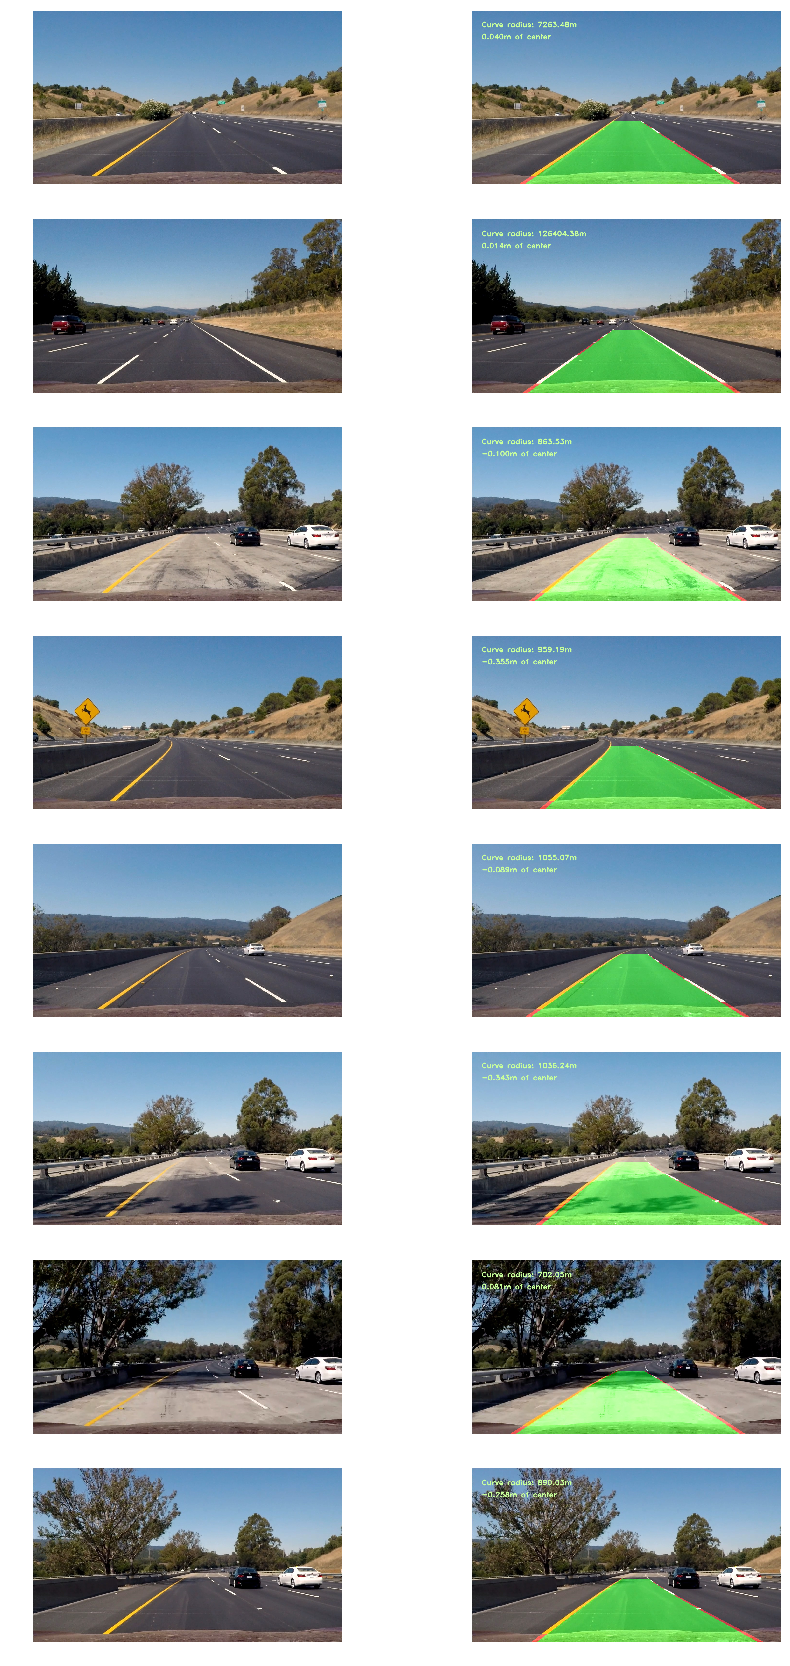

In [19]:
import ntpath

# Make a list of example images
images = glob.glob('.\\test_images\\*.jpg')
#images = glob.glob('.\\challenge\\*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images), 2, figsize=(15, 30))
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()
                  
i = 0
for image in images:
    output_file = '.\\output_images\\' + ntpath.basename(image)
    #output_file = '.\\challenge_output\\' + ntpath.basename(image)
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mod_img = img_procesing_pipeline_2(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(mod_img)
    axs[i].axis('off')
    i += 1
    mod_img = cv2.cvtColor(mod_img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(output_file, mod_img)
    

In [20]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
        self.lane_width = -1
        
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1. or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


In [21]:
def img_procesing_pipeline_final(img):
    new_img = np.copy(img)
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    binary_warped, warped, Minv = img_procesing_pipeline_1(new_img)

    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        #l_line.type.append(1)
        select = 1
        l_fit, r_fit, l_lane_inds, r_lane_inds, out_img, all_hist = sliding_window_polyfit(binary_warped, margin, minpix)
    else:
        #l_line.type.append(2)
        select = 2
        l_fit, r_fit, l_lane_inds, r_lane_inds = find_lane_from_prev_fit(binary_warped, l_line.best_fit, r_line.best_fit, margin + 20)
         
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if (l_line.lane_width == -1) :
            l_line.lane_width = x_int_diff
            print (l_line.lane_width)
        elif abs(l_line.lane_width - x_int_diff) > 150:
            #l_line.type.append(3)
            select = (l_line.lane_width - x_int_diff)
            l_fit = None
            r_fit = None
            
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    if l_fit is not None and r_fit is not None:
        left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
        right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]
        rad_l, rad_r, d_center = cal_curvature_and_distance_from_center(img, binary_warped, l_fit, r_fit, 
                                                               left_fitx, right_fitx, 0, True)
        if ((rad_l * rad_r) > 0) :
            l_line.add_fit(l_fit, l_lane_inds)
            r_line.add_fit(r_fit, r_lane_inds)
        else :
            select = 4
            
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        #l_line.type.append(4)
        left_fitx = l_line.best_fit[0]*ploty**2 + l_line.best_fit[1]*ploty + l_line.best_fit[2]
        right_fitx = r_line.best_fit[0]*ploty**2 + r_line.best_fit[1]*ploty + r_line.best_fit[2]
        rad_l, rad_r, d_center = cal_curvature_and_distance_from_center(img, binary_warped, l_line.best_fit, r_line.best_fit, 
                                                               left_fitx, right_fitx, 0, False)
        img_out1 = draw_lane(new_img, binary_warped, l_line.best_fit, r_line.best_fit, Minv)
        img_out = write_data(img_out1, (rad_l+rad_r)/2, d_center, select)
    else:
        #l_line.type.append(3)
        select = 5
        img_out = new_img
        img_out = write_data(img_out, 0, 0, select)
    
    return img_out


In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

l_line = Line()
r_line = Line()
white_output = 'output_video/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(img_procesing_pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

637.273405485
[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:33<00:00,  5.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video.mp4 

Wall time: 3min 35s


In [23]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
l_line = Line()
r_line = Line()
white_output = 'output_video/challenge_video.mp4'
#clip1 = VideoFileClip("challenge_video.mp4").subclip(0,5)
clip2 = VideoFileClip("challenge_video.mp4")
#clip1.save_frame("test_images/challenge01.jpeg", t=0.0) # saves the frame at time = 0.25s
white_clip = clip2.fl_image(img_procesing_pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

582.302534495
[MoviePy] >>>> Building video output_video/challenge_video.mp4
[MoviePy] Writing video output_video/challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:20<00:00,  6.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/challenge_video.mp4 

Wall time: 1min 22s


In [24]:
#time = [0.001, 1.101, 2.101, 2.904, 3.601, 3.853, 3.913, 4.049, 4.310, 4.350, 4.390, 5.352, 9.601, 15.335]
#for i in range(len(time)):
#    filename = "challenge/challenge"+'{:01.0f}'.format(i)+".jpg"
#    clip2.save_frame(filename, time[i]) 

In [25]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
l_line = Line()
r_line = Line()

white_output = 'output_video/harder_challenge_video.mp4'
clip3 = VideoFileClip("harder_challenge_video.mp4").subclip(0,5)
#clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip3.fl_image(img_procesing_pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

614.068200877
[MoviePy] >>>> Building video output_video/harder_challenge_video.mp4
[MoviePy] Writing video output_video/harder_challenge_video.mp4


 99%|███████████████████████████████████████████████████████████████████████████████▎| 125/126 [00:21<00:00,  5.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/harder_challenge_video.mp4 

Wall time: 23.5 s


In [26]:
#time = [0.203, 2.016, 2.816, 4.641, 5.934, 7.341]
#for i in range(len(time)):
#    filename = "harder_challenge/challenge"+'{:01.0f}'.format(i)+".jpg"
#    clip3.save_frame(filename, time[i]) 